# Clustering

- Partitioning Clustering
- Hierarchical Clustering
- Density Based Clustering
- Probabilistic-Model based Clustering
- Clustering Evaluation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, Birch, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from numpy.random import uniform
from random import sample
from scipy import stats
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

In [2]:
clustering_df = pd.read_csv(r'featureIng_dataframe.csv')
clustering_df = clustering_df.drop(columns=['Exited', 'Complain'])
scaler = StandardScaler()
clustering_df[['CreditScore', 'Balance', 'EstimatedSalary']] = scaler.fit_transform(clustering_df[['CreditScore', 'Balance', 'EstimatedSalary']])
clustering_df.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Point Earned,Gender_Female,...,Geography_Spain,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Age_30-40,Age_40-50,Age_50-60,Age_<30,Age_>60
0,-0.326221,2,-1.225848,0,1,1,0.021886,2,464,1,...,0,1,0,0,0,0,1,0,0,0
1,-0.440036,1,0.117350,0,0,1,0.216534,3,456,1,...,1,1,0,0,0,0,1,0,0,0
2,-1.536794,8,1.333053,1,1,0,0.240687,3,377,1,...,0,1,0,0,0,0,1,0,0,0
3,0.501521,1,-1.225848,1,0,0,-0.108918,5,350,1,...,0,0,1,0,0,1,0,0,0,0
4,2.063884,2,0.785728,0,1,1,-0.365276,5,425,1,...,1,0,1,0,0,0,1,0,0,0


### Partitioning Clustering

- *K-means*

We will first try to find the optimal number of clusters for K-means. This will mean testing increasing numbers of clusters and stopping when the change in inertia between next cluster counts becomes insignificant, as defined by a specified threshold.

Text(0, 0.5, 'Inertia')

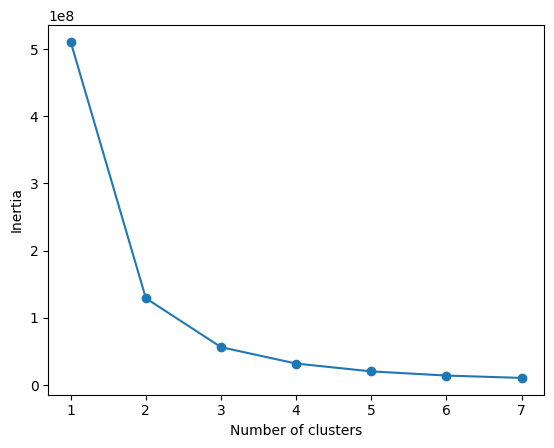

In [3]:
means = []
inertias = []
threshold = 0.25 
k = 1
prev_inertia = None

while True:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_df)
    
    means.append(k)
    inertias.append(kmeans.inertia_)
    
    if prev_inertia is not None:
        inertia_diff = abs(prev_inertia - kmeans.inertia_)
        if inertia_diff / prev_inertia < threshold:
            break
    
    prev_inertia = kmeans.inertia_
    k += 1

plt.plot(means, inertias, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

The inertia plot shows the "elbow" at 3 clusters, where more increases provide minimal improvement, so we will use 3 clusters as the optimal choice for K-means.

In [4]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(clustering_df)

KMeans(n_clusters=3)

In [5]:
clustering_df['Cluster'] = kmeans.labels_

cluster_sizes = clustering_df['Cluster'].value_counts()
print("\nCluster Sizes:")
print(cluster_sizes)


Cluster Sizes:
Cluster
2    3374
0    3357
1    3269
Name: count, dtype: int64


K-means algorithm has grouped the data into three clusters, with Cluster 2 having the largest number of points, followed by Cluster 1, and then Cluster 0. The distribution of data points across clusters is relatively balanced and they are fairly similar in terms of the number of data points they contain.

In [6]:
print("\nInertia:", kmeans.inertia_)


Inertia: 56405954.087529615


### Hierarchical Clustering

- *BIRCH Clustering*

BIRCH can automatically form clusters based on a user-defined threshold parameter. This controls the maximum radius of a subcluster (or "leaf") in the clustering feature tree.

In [7]:
clustering_df.drop(columns='Cluster', inplace=True)
birch = Birch(threshold=0.25)
birch.fit(clustering_df)

Birch(threshold=0.25)

In [8]:
clustering_df['Cluster'] = birch.labels_

cluster_sizes = clustering_df['Cluster'].value_counts()
print("\nCluster Sizes:")
print(cluster_sizes)


Cluster Sizes:
Cluster
0    4310
1    3385
2    2305
Name: count, dtype: int64


The cluster sizes show that Cluster 0 is the largest with 4.295 members, followed by Cluster 1 with 3.400, and Cluster 2 with 2.305, Clustter 0 having significantly more members than the 2 others and Cluster 1 being also bigger than Cluster 2. This could suggest that some clusters represent more common patterns or dominant groups in the dataset.

###  Density Based Clustering

- DBSCAN clustering

Lets first try choosing the right values for eps (the maximum distance between two points for them to be considered neighbors) and min_samples (the number of samples in a neighborhood for a point to be considered a core point) for DBSCAN.

If eps is too large, DBSCAN will consider most points as neighborsand in the other side if eps is too small, DBSCAN will only consider points that are very close to each other as neighbors. This coul lead few large clusters or many small clusters.

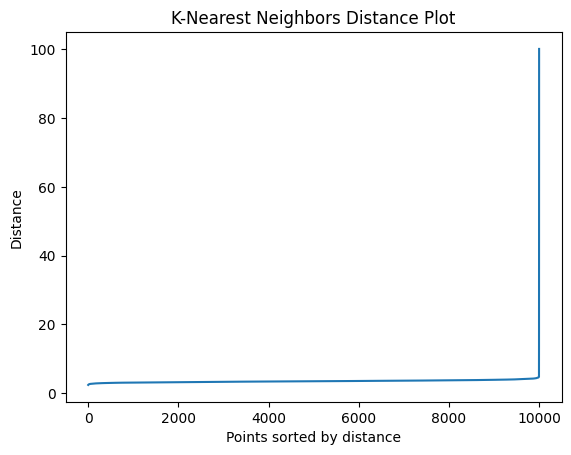

In [9]:
clustering_df.drop(columns='Cluster', inplace=True)
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(clustering_df)

distances, indices = neighbors_fit.kneighbors(clustering_df)
distances = np.sort(distances[:, -1], axis=0)

plt.plot(distances)
plt.title('K-Nearest Neighbors Distance Plot')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance')
plt.show()

The curve doesn't start to grow significantly until the 10,000th point, this could indicate that the data has a very large spread, and we're looking at a global density scale. t might be that our data is sparsely distributed, and DBSCAN may not be the best choice for this data. Due to this we sill try wiht considerably hig values of eps.

In [10]:
dbscan = DBSCAN(eps=10, min_samples=200, metric='euclidean')
dbscan.fit(clustering_df)

DBSCAN(eps=10, min_samples=200)

"min_samples" specifies the minimum number of points required to form a dense region. Putting "min_samples" at 200, DBSCAN will only create clusters with at least 200 points, which helps in ignoring small, potentially noisy clusters that are too sparse.

In [11]:
clustering_df['Cluster'] = dbscan.labels_

cluster_sizes = clustering_df['Cluster'].value_counts()
print("\nCluster Sizes:")
print(cluster_sizes)


Cluster Sizes:
Cluster
 0    7239
 1    2757
-1       4
Name: count, dtype: int64


This algorithm made Cluster 0 with 7239 points and Cluster 1 with 2757 points, while 4 points were classified as noise (outliers, labeled as -1). This suggests the data primarily forms two dense groups with minimal noise.

### Probabilistic-Model Based Clustering

- *Gaussian Mixture* clustering

We’ll use metrics like the Bayesian Information Criterion (BIC) or Akaike Information Criterion (AIC) to evaluate different numbers of components. Lower values of BIC/AIC indicate a better fit while penalizing model complexity.

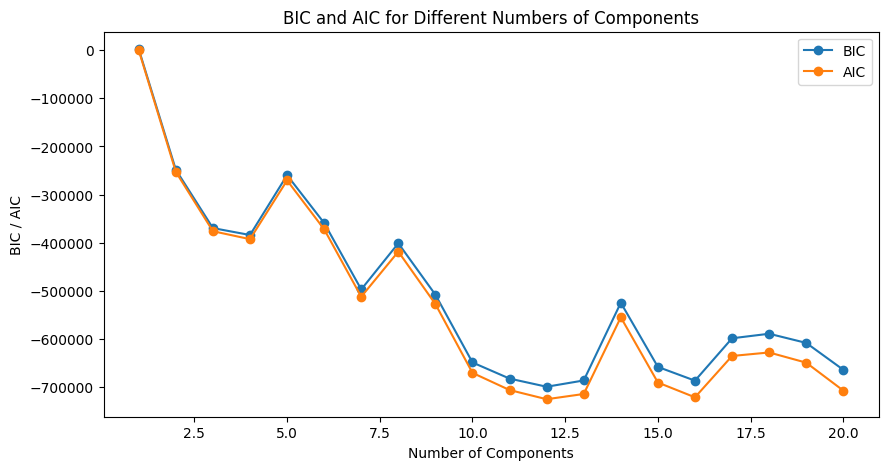

In [12]:
clustering_df.drop(columns='Cluster', inplace=True)
n_components = range(1, 21)
bics = []
aics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(clustering_df)
    bics.append(gmm.bic(clustering_df))
    aics.append(gmm.aic(clustering_df))

plt.figure(figsize=(10, 5))
plt.plot(n_components, bics, label='BIC', marker='o')
plt.plot(n_components, aics, label='AIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC / AIC')
plt.title('BIC and AIC for Different Numbers of Components')
plt.legend()
plt.show()

The plot shows that both BIC and AIC decrease significantly up to 10 components, indicating better model fit, but the improvement slows afterward.Therefore, 10 components is likely the optimal balance between model complexity and fit. This large number of components allows the model to capture these subtleties more accurately.

In [13]:
gmm = GaussianMixture(n_components=10)
gmm.fit(clustering_df)

GaussianMixture(n_components=10)

In [14]:
labels = gmm.predict(clustering_df)
cluster_sizes = np.unique(labels, return_counts=True)

print("Cluster Sizes:")
for cluster, size in zip(*cluster_sizes):
    print(f"Cluster {cluster}: {size} points")

Cluster Sizes:
Cluster 0: 271 points
Cluster 1: 700 points
Cluster 2: 607 points
Cluster 3: 255 points
Cluster 4: 863 points
Cluster 5: 6 points
Cluster 6: 937 points
Cluster 7: 1718 points
Cluster 8: 704 points
Cluster 9: 3939 points


The GMM with 10 clusters shows diverse customer segments, with Cluster 6 representing the largest group (3,567 points), likely the most common customer behavior. Clusters 1 and 2 are small, possibly indicating rare or outlier groups. Larger clusters like 3, 5, and 8 suggest significant customer segments with shared characteristics.

### Clustering Evaluation

1. Cluster tendency: Hopkins Statistic

Our Hopkin test implementation converts the input data into a NumPy array and uses 5% of the data size as the sample. Nearest neighbor distances are computed for the uniform random sample (u_distances) and the second-nearest neighbor distances for the data sample (w_distances). The Hopkins statistic is then calculated as the ratio of the uniform distances sum to the total of uniform and real data distances.

In [15]:
def hopkins_statistic(X):
    
    X=X.values
    sample_size = int(X.shape[0]*0.05)
    

    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
   
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0]
    
    #actual sample
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    H = u_sum/ (u_sum + w_sum)
    return H

In [16]:
print("\nHopkins Statistic:", hopkins_statistic(clustering_df))


Hopkins Statistic: 0.591325243397705


Since multiple calls of the function will result in different values of H, we call the function and compute Hopkins' Statistic multiple times, and take its average.

In [17]:
l = []
for i in range(20):
    H=hopkins_statistic(clustering_df)
    l.append(H)

print("\nHopkins Statistic:", np.mean(l))


Hopkins Statistic: 0.5856994656642361


A Hopkins statistic of 0.583 indicates that the data is likely uniformly distributed, showing no distinct clustering
structure, this means a moderate clustering tendency, with some structure but not strongly pronounced.

2. Internal Evaluation Methods: Shilhouette Coefficent, Calinski-Harabasz
Index and Davies-Bouldin Index

In [18]:
def evaluate_clustering(models, X):
    results = {}
    for name, model in models.items():
        labels = (
            model.labels_ if hasattr(model, "labels_") else model.predict(X)
        )

        if len(set(labels)) <= 1 or (set(labels) == {-1}):
            results[name] = {"Silhouette": "N/A", "Calinski-Harabasz": "N/A", "Davies-Bouldin": "N/A"}
            continue

        results[name] = {
            "Silhouette": silhouette_score(X, labels),
            "Calinski-Harabasz": calinski_harabasz_score(X, labels),
            "Davies-Bouldin": davies_bouldin_score(X, labels),
        }
    return results

In [19]:
models = {"KMeans": kmeans, "Birch": birch, "DBSCAN": dbscan, "GMM": gmm}
metrics = evaluate_clustering(models, clustering_df)

for model, scores in metrics.items():
    print(f"\n{model} Metrics:")
    for metric, value in scores.items():
        print(f"  {metric}: {value}")


KMeans Metrics:
  Silhouette: 0.5919619717523297
  Calinski-Harabasz: 40243.386871152026
  Davies-Bouldin: 0.49809471697095437

Birch Metrics:
  Silhouette: 0.5603096662513172
  Calinski-Harabasz: 33613.68570021595
  Davies-Bouldin: 0.49610383070871494

DBSCAN Metrics:
  Silhouette: 0.4327036561795056
  Calinski-Harabasz: 7507.734000111658
  Davies-Bouldin: 1.2753910551975063

GMM Metrics:
  Silhouette: -0.4616507205757455
  Calinski-Harabasz: 42.6236279214856
  Davies-Bouldin: 104.55813223463267


- Shillouette

    - kmeans: (0.59) Moderate clustering quality; data points are fairly well-separated between clusters.
    - birch: (0.56) Similar to KMeans.
    - dbscan: (0.43) Indicates weaker clustering quality.
    - gmm: (-0.46) Negative value indicates poor clustering, with many points assigned to incorrect clusters.
- Calinski-Harabasz
    - kmeans: (40243.31) High value indicates well-defined clusters with good separation and compactness.
    - birch: (33613.69) Lower than KMeans, indicating slightly less compact.
    - dbscan: (7507.73) Much lower, suggesting less compact or poorly separated clusters.
    - gmm: (42.62): Extremely low.
- Davies-Bouldin
    - kmeans: (0.50) Low value suggests good clustering quality.
    - birch: (0.50) Comparable clustering quality to KMeans.
    - dbscan: (1.27) Higher value reflects worse clustering quality.
    - gmm: (104.56) Very high value, indicating clusters are poorly defined.

KMeans performs the best, providing well-defined, compact, and well-separated clusters. Birch is slightly less effective but still produces reasonable results. DBSCAN and GMM struggle, with DBSCAN hindered by noise and GMM failing to form meaningful clusters.

3. External Evaluation Methods

As we don't e know the expected labels for each datapoint, we will simulate them by using the cluster assignments from KMeans as the true labels, as it is the most reliable algorithm based on internal evaluation metrics.

In [20]:
def evaluate_clustering_external(models, X, true_labels):
    results = {}
    for name, model in models.items():

        labels = (
            model.labels_ if hasattr(model, "labels_") else model.predict(X)
        )

        if len(set(labels)) <= 1 or (set(labels) == {-1}):
            results[name] = {"Homogeneity": "N/A", "Completeness": "N/A", "V-measure": "N/A"}
            continue

        homogeneity = homogeneity_score(true_labels, labels)
        completeness = completeness_score(true_labels, labels)
        v_measure = v_measure_score(true_labels, labels)

        results[name] = {
            "Homogeneity": homogeneity,
            "Completeness": completeness,
            "V-measure": v_measure,
        }
    return results

In [21]:
models_to_evaluate = {key: models[key] for key in ["Birch", "DBSCAN", "GMM"]}
metrics = evaluate_clustering_external(models_to_evaluate, clustering_df, kmeans.labels_)
for model, scores in metrics.items():
    print(f"\n{model} Metrics:")
    for metric, value in scores.items():
        print(f"  {metric}: {value}")


Birch Metrics:
  Homogeneity: 0.7767039943752623
  Completeness: 0.7991341537807308
  V-measure: 0.7877594409165759

DBSCAN Metrics:
  Homogeneity: 0.4078444291989233
  Completeness: 0.7564820286653022
  V-measure: 0.5299664524435665

GMM Metrics:
  Homogeneity: 0.022341370951954452
  Completeness: 0.013325966577614215
  V-measure: 0.01669428576534552


The Birch model shows the best clustering performance with high Homogeneity, Completeness, and V-measure, indicating it more accurately captures the true data structure. DBSCAN performs decently, particularly in Completeness, but struggles with Homogeneity. The GMM model performs poorly across all metrics, suggesting it fails to effectively cluster the data.

### Most Reliable Method Visualization

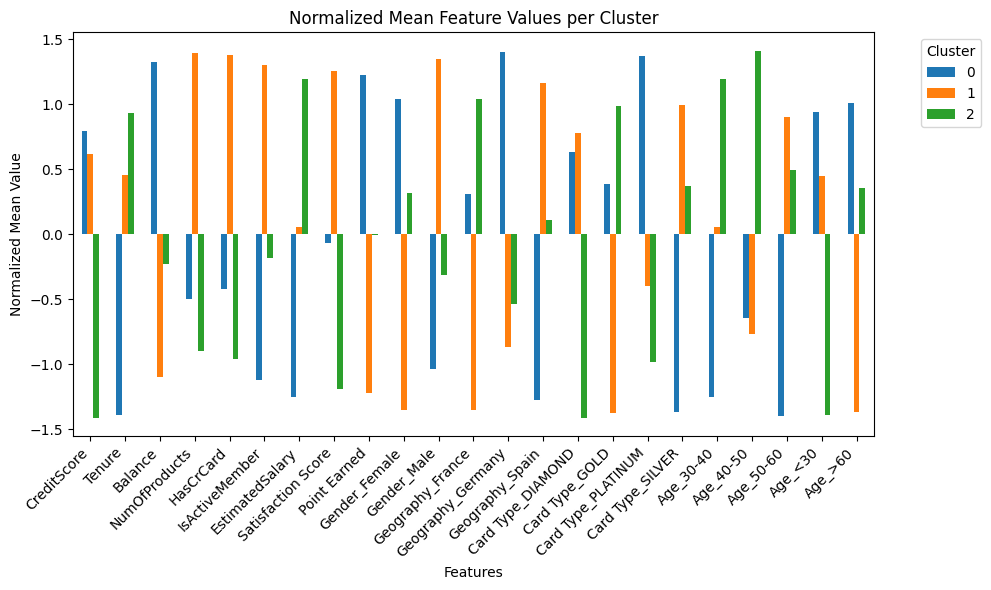

In [22]:
clustering_df['Cluster'] = kmeans.labels_
cluster_profile = clustering_df.groupby('Cluster').mean()

scaler = StandardScaler()
normalized_cluster_profile = pd.DataFrame(scaler.fit_transform(cluster_profile), columns=cluster_profile.columns, index=cluster_profile.index)

normalized_cluster_profile.T.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Features')
plt.ylabel('Normalized Mean Value')
plt.title('Normalized Mean Feature Values per Cluster')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

This plot shows the mean values of each feature for each cluster. We normalized the feature values to ensure that all features have a similar scale, making it easier to compare them visually. This prevents features with larger ranges, like "Point Earned," from dominating the plot.

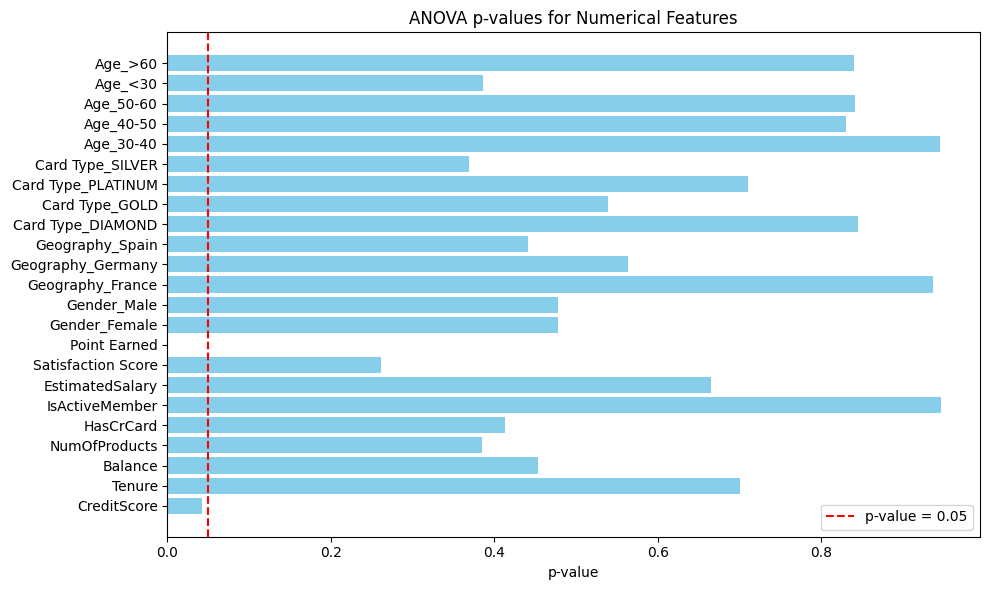

In [23]:
p_values = []

# Perform ANOVA for each numerical feature against cluster labels
for column in clustering_df.select_dtypes(include=['float64', 'int64']):
    f_stat, p_value = stats.f_oneway(*[clustering_df[column][clustering_df['Cluster'] == i] for i in range(3)])
    p_values.append((column, p_value))

p_values_df = pd.DataFrame(p_values, columns=['Feature', 'p-value'])

plt.figure(figsize=(10, 6))
plt.barh(p_values_df['Feature'], p_values_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.title('ANOVA p-values for Numerical Features')
plt.axvline(x=0.05, color='red', linestyle='--', label='p-value = 0.05')
plt.legend()
plt.tight_layout()
plt.show()

The ANOVA p-value plot shows how statistically significant each feature is in differentiating the clusters. A low p-value (below 0.05) indicates that the feature is highly significant. For instance, PointEarned and CreditScore have low p-values, suggesting they significantly differentiate the clusters. On the other hand, Age_30-40, Geography_France, and IsActiveMember have higher p-values, indicating they do not play a significant role in clustering. This means these features have less impact on the variance between clusters, and their values are similar across clusters.

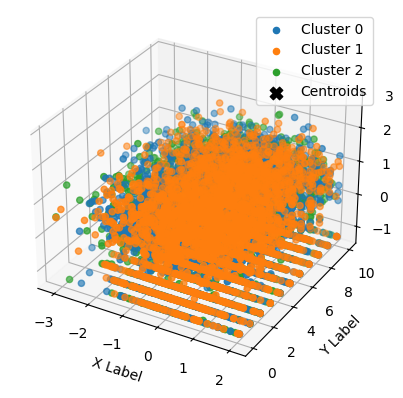

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

centroids = kmeans.cluster_centers_
u_labels = np.unique(kmeans.labels_)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in u_labels:
    ax.scatter(clustering_df.iloc[kmeans.labels_ == i, 0], 
               clustering_df.iloc[kmeans.labels_ == i, 1], 
               clustering_df.iloc[kmeans.labels_ == i, 2], 
               label=f"Cluster {i}")


ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=80, color='k', marker='X', label="Centroids")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()

plt.show()


As concluded and mentioned in the hpkins test, data is uniformly distributed, meaning there is no clear clustering structure. This is reflected in the visualization, where clusters are not clearly defined and hard to distinguish. As a result, applying clustering algorithms may not produce meaningful insights. Clustering methods are best suited for data with inherent groupings, which this dataset lacks. Therefore, other analysis techniques should be considered instead of clustering.